Khai báo thư viện

In [1]:
import pandas as pd
from sklearn.impute import SimpleImputer

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Chọn features và labels

In [2]:
X = train[['Pclass', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked']]
y = train['Survived']



Chuyển đổi chữ sang số

In [3]:
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

imputer = SimpleImputer(strategy='mean')
X[num_cols] = imputer.fit_transform(X[num_cols])

X[cat_cols] = X[cat_cols].fillna('missing')

for col in cat_cols:
    X[col] = pd.factorize(X[col])[0]

C:\Users\MSI VN\AppData\Local\Temp\ipykernel_19672\3411822210.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[num_cols] = imputer.fit_transform(X[num_cols])
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_19672\3411822210.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_cols] = X[cat_cols].fillna('missing')
C:\Users\MSI VN\AppData\Local\Temp\ipykernel_19672\3411822210.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col

Chia train/test

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)



Train model

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


logis = LogisticRegression(max_iter=1000, random_state=42)
logis.fit(X_train, y_train)
y_pred_logis = logis.predict(X_valid)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_valid)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_valid)

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_valid)

xgb = XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=4,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_valid)

import pandas as pd

results = []
models = {
    "Decision Tree": y_pred_dt,
    "Logistic Regression": y_pred_logis,
    "Random Forest": y_pred_rf,
    "KNN": y_pred_knn,
    "XGBoost": y_pred_xgb
}

for name, y_pred in models.items():
    acc = accuracy_score(y_valid, y_pred)
    pre = precision_score(y_valid, y_pred)
    rec = recall_score(y_valid, y_pred)
    f1 = f1_score(y_valid, y_pred)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(pre, 4),
        "Recall": round(rec, 4),
        "F1-Score": round(f1, 4)
    })

df_results = pd.DataFrame(results)
df_results.sort_values(by="F1-Score", ascending=False).reset_index(drop=True)

,Model,Accuracy,Precision,Recall,F1-Score
0,Random Forest,0.8268,0.8116,0.7568,0.7832
1,XGBoost,0.8156,0.8154,0.7162,0.7626
2,Logistic Regression,0.7989,0.7714,0.7297,0.7500
3,Decision Tree,0.7821,0.7465,0.7162,0.7310
4,KNN,0.7039,0.6780,0.5405,0.6015


### Tiếp theo ta sẽ chọn ra 3 model được đánh giá cao nhất
* RandomForest có F1 cao nhất, Recall cao nhất, Accuracy cao nhất
* XGBoost có precision cao nhất, F1 Accuracy tương đối cao
* LogisticRegression có hiệu suất tương đối, được đánh giá cao hơn DecisionTree và KNN


In [6]:
param_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

param_rf = {
    'n_estimators': [100, 200, 300],   
    'max_depth': [None, 5, 10, 15],    
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4],     
    'bootstrap': [True, False]         
}

param_lr = {
    'penalty': ['l1', 'l2', 'elasticnet', None],  
    'C': [0.01, 0.1, 1, 10, 100],                 
    'solver': ['liblinear', 'saga'],              
    'max_iter': [100, 200, 500]                   
}

In [7]:
from sklearn.model_selection import GridSearchCV

models_params = [
    (RandomForestClassifier(), param_rf, "Random Forest"),
    (LogisticRegression(), param_lr, "LogisticRegression"),
    (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_xgb, "XGBoost")
]

best_models = []
for model, params, name in models_params:
    grid = GridSearchCV(model, params, cv=5, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    print(f"\nTham số tốt nhất của {name}:")
    print(grid.best_params_)
    print(f"Độ chính xác tốt nhất: {grid.best_score_:.4f}")
    
    best_models.append({
        'Model': name,
        'Best Params': grid.best_params_,
        'Best Score': grid.best_score_
    })


c:\ProgramData\anaconda3\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Tham số tốt nhất của Random Forest:
{'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Độ chính xác tốt nhất: 0.8342


c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
225 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
75 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py", line 1194, in fit
    solver =


Tham số tốt nhất của LogisticRegression:
{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Độ chính xác tốt nhất: 0.7991

Tham số tốt nhất của XGBoost:
{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}
Độ chính xác tốt nhất: 0.8329


In [11]:

best_models_df

,Model,Best Params,Best Score
0,Random Forest,"{'bootstrap': False, 'max_depth': 5, 'min_samp...",0.834246
1,LogisticRegression,"{'C': 0.1, 'max_iter': 100, 'penalty': 'l2', '...",0.799114
2,XGBoost,"{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",0.832857


### Vậy ta đã chọn ra được model tốt nhất là RandomForest với độ chính xác tốt nhất là 0.8356

Lấy model tốt nhất đi dự đoán 

In [8]:
test_data = pd.read_csv("./data/test.csv")
test_data = test_data[['Pclass', 'Name', 'Sex', 'Age', 'Fare', 'SibSp', 'Parch', 'Embarked']]
test_data = test_data.fillna(test_data.mean(numeric_only=True))
test_data = test_data.fillna('missing')

best_model = RandomForestClassifier(bootstrap= True, max_depth= 5, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 200)
test_data = pd.get_dummies(test_data)
missing_cols = set(X_train.columns) - set(test_data.columns)
for c in missing_cols:
    test_data[c] = 0
test_data = test_data[X_train.columns]

best_model.fit(X_train, y_train)
y_test_pred = best_model.predict(test_data)

submission = pd.DataFrame({
    "PassengerId": pd.read_csv("./data/test.csv")["PassengerId"],
    "Survived": y_test_pred
})
submission.to_csv("./data/submissionWithUnprocessedData.csv", index=False)
print("\n Đã tạo submissionWithUnprocessedData.cs")



 Đã tạo submissionWithUnprocessedData.cs


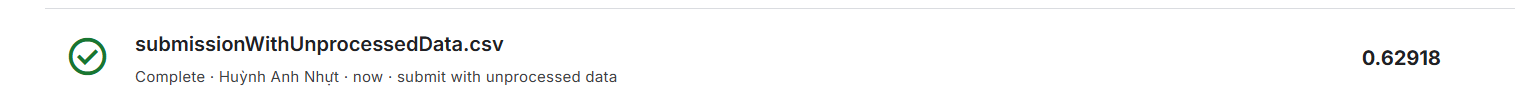

In [9]:
from IPython.display import Image, display

display(Image(filename='./image/submitwithunprocessed.png'))

### Tổng kết: Sau khi gửi file submit lên kaggle thì ta được kết quả là 0.62918 